In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import dataframe_image as dfi

np.random.seed(90)

/Users/merino/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
ev = pd.read_csv('Data/ev.csv')
gas = pd.read_csv('Data/gas.csv')
dis = pd.read_csv('Data/dis.csv')
hyb = pd.read_csv('Data/hyb.csv')

# Drive Cycle
us06 = pd.read_csv('Data/us06.csv')
wltc = pd.read_csv('Data/wltc.csv')

### Additional Data

From previous section:

\begin{align*}
    M & = m_a + m_b + m_c \\
\end{align*}

Wheel specifications:

\begin{align*}
    r_a &= 0.3 \text{ m} \\
    r_c &= 0.33 \text{ m} \\
    m_a &= 9 \text{ kg} \\
    m_c &= 9 \text{ kg}
\end{align*}

Hence,

\begin{equation*}
    m = m_a + m_c = 18kg
\end{equation*}

Drag specifications (specified in section 'Theoretical Model'):

\begin{align*}
    \rho_a & = 1.225 \text{ $\frac{\text{kg}}{\text{m}^3}$} \\
    c_D & = 0.22 \\
    A_F & = 2 \text{ m}^2
\end{align*}

The value $h\approx H$:

\begin{equation*}
    h = CoG - r_a \approx CoG - r_c
\end{equation*}

In [3]:
c_R = .12 # Rolling Resistance Coefficient
r_a = .33 # Wheel a Radius
r_c = .3 # Wheel c Radius
g = 9.81 # Gravitational Acceleration
m_a = m_c = 9 # Mass of Wheel a and c
m = m_a + m_c # Combined Mass of Wheel a and c
rho_a = 1.225 # Air Density at T = 15°C

for cars in [ev, gas, hyb, dis]:
    # Define the value of h: h = CoG - r_a ~ CoG - r_c = H
    cars['h'] = cars['CoG'] - r_a

The object is to represent the Force in the form of

\begin{equation*}
    \boxed{
        F = A + B\cdot \dot x + C \cdot \dot x^2 + D \ddot x,
    }
\end{equation*}

where $x$ is the position, $\dot x$ the velocity and $\ddot x$ the acceleration.

In [4]:
def dRWD(r_a, c_R, a, h):
    """ Returns the denominator for RWD """
    return 2/3 + 5/3 * r_a * c_R / ( 2 * a + h * c_R )

def dFWD(r_c, c_R, a, h):
    """ Return the denominator for FWD """
    return 2/3 - 5/3 * r_c * c_R / ( 2 * a - h * c_R ) 

def A(EDT, m, a, h):
    # EDT = veh['Drive']
    # m = veh['Body Curb Weight']
    # a = veh['2a']
    # h = veh['Height of Center of Gravity']
    a = a/2
    if  EDT == 'rear wheel drive':
        return 5 / 3 * m / ( 2 + h / a * c_R ) * c_R * g / dRWD( r_a, c_R, a, h) 
    elif EDT == 'front wheel drive':
        return 5 / 3 * m / ( 2 - h / a * c_R ) * c_R * g / dFWD( r_c, c_R, a, h)
    else: #elif EDT == 'all wheel drive':
        return 5 / 4 * c_R * m * g 
    
def C(EDT, a, h, c_D, A_F):
    a = a/2
    if  EDT == 'rear wheel drive':
        return .5 * rho_a * c_D * A_F / dRWD( r_a, c_R, a, h)
    elif EDT == 'front wheel drive':
        return .5 * rho_a * c_D * A_F / dFWD( r_c, c_R, a, h)
    else: #elif EDT == 'all wheel drive':
        return 3 / 8 * rho_a * c_D * A_F
    
def D(EDT, m, a, h):
    a = a/2
    if  EDT == 'rear wheel drive':
        return ( m - 5 / 3 * ( m_c + m_a ) / ( 2 * a + h * c_R ) * c_R * h ) / dRWD( r_a, c_R, a, h)
    elif EDT == 'front wheel drive':
        return ( m + 5 / 3 * ( m_c + m_a ) / ( 2 * a - h * c_R ) * c_R * h ) / dFWD( r_c, c_R, a, h)
    else: #elif EDT == 'all wheel drive':
        return 3 / 4 * m
    

In [5]:
for i in [gas, dis, hyb, ev]:
    i['A'] = np.vectorize(A)(i['Drive'], i['M'], i['2a'], i['h'])
    i['C'] = np.vectorize(C)(i['Drive'], i['M'], i['h'], i['c_D'], i['A_F'])
    i['D'] = np.vectorize(D)(i['Drive'], i['M'], i['2a'], i['h'])

### Force and Power

In the paper before, we already derived each Force equation for the rear-wheel drive (RWD), front-wheel drive (FWD) and all-wheel drive (AWD).

The (Tractive) Force $F_T$ and Power $P_T$ needed:

\begin{align*}
    F_T(t) & = A + B\cdot \dot x + C\cdot \dot x^2 + D\cdot \ddot x \\
    P_T(t) & = \left( A + B\cdot \dot x + C\cdot \dot x^2 + D\cdot \ddot x \right)\cdot \dot x
\end{align*}

Total Power consumed:

\begin{equation*}
    P(t) = \left( A + B\cdot \dot x + C\cdot \dot x^2 + D\cdot \ddot x \right)\cdot \dot x + P_{HVAC}
\end{equation*}


In [6]:
def F_T(A, C, D, v, a, B=0):
    """ Returns the Force needed for the Drive Cycle
        (Output)
            [F_T]: N"""
    return A + B*v + C*v**2 + D*a

def P_T(A, C, D, v, a, B=0):
    """ Returns the Power needed for the Drive Cycle
        (Output)
            [P_T] W"""
    return (A + B*v + C*v**2 + D*a)*v

def P(A, C, D, v, a, P_hvac=1.5, B=0):
    """ Returns the Power needed for the Drive Cycle
        (Output)
            [P]: W"""
    return (A + B*v + C*v**2 + D*a)*v + P_hvac*1e3

In [7]:
x = np.random.randint(15)

t = us06['Time']
v = us06['Velocity']
a = us06['Acceleration']
s = us06['Distance']


In [8]:
def Tractives(dc, name):
    t = dc['Time']
    v = dc['Velocity']
    a = dc['Acceleration']

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, hspace=0)

    F_Tg = F_T(gas['A'].iloc[x], gas['C'].iloc[x], gas['D'].iloc[x], v, a)
    P_g = P(gas['A'].iloc[x], gas['C'].iloc[x], gas['D'].iloc[x], v, a)

    F_Td = F_T(dis['A'].iloc[x], dis['C'].iloc[x], dis['D'].iloc[x], v, a)
    P_d = P(dis['A'].iloc[x], dis['C'].iloc[x], dis['D'].iloc[x], v, a)

    F_Te = F_T(ev['A'].iloc[x], ev['C'].iloc[x], ev['D'].iloc[x], v, a)
    P_e = P(ev['A'].iloc[x], ev['C'].iloc[x], ev['D'].iloc[x], v, a)

    F_Th = F_T(hyb['A'].iloc[x], hyb['C'].iloc[x], hyb['D'].iloc[x], v, a)
    P_h = P(hyb['A'].iloc[x], hyb['C'].iloc[x], hyb['D'].iloc[x], v, a)

    # Defines axes
    ax1, ax2 = gs.subplots(sharex=True)

    # Loops through the x-axes to set each label, grid and limit
    for ax in fig.axes:
        ax.set_xlabel("Time [s]")
        ax.grid()
        ax.set_xlim(dc['Time'].iloc[0], dc['Time'].iloc[-1])

    # Setting each label for the y axes
    ax1.set_ylabel('Tractive Force [kN]', color='mediumblue')
    ax2.set_ylabel('Power [kW]', color='slateblue')

    # Labels for vehicles:
    lbl_g = gas['Vehicle'].iloc[x] + ' (' + gas['Engine'].iloc[x] + ', ' + gas['Body'].iloc[x] + ', ' + str(int(gas['M'].iloc[x])) + ' kg)'
    lbl_d = dis['Vehicle'].iloc[x] + ' (' + dis['Engine'].iloc[x] + ', ' + dis['Body'].iloc[x] + ', ' + str(int(dis['M'].iloc[x])) + ' kg)'
    lbl_e = ev['Vehicle'].iloc[x] + ' (' + ev['Engine'].iloc[x] + ', ' + ev['Body'].iloc[x]+ ', ' + str(int(ev['M'].iloc[x])) + ' kg)'
    lbl_h = hyb['Vehicle'].iloc[x] + ' (' + hyb['Engine'].iloc[x] + ', ' + hyb['Body'].iloc[x] + ', ' + str(int(hyb['M'].iloc[x])) + ' kg)'

    # Tractive Power plots
    ax1.plot(t, F_Te/1e3, c='cyan', label=lbl_e)
    ax1.plot(t, F_Th/1e3, c='lime', label=lbl_h)
    ax1.plot(t, F_Tg/1e3, c='maroon', label=lbl_g)
    ax1.plot(t, F_Td/1e3, c='magenta', label=lbl_d)

    # Tractive Power plots
    ax2.plot(t, P_e/1e3, c='cyan', label=lbl_e)
    ax2.plot(t, P_h/1e3, c='lime', label=lbl_h)
    ax2.plot(t, P_g/1e3, c='maroon', label=lbl_g)
    ax2.plot(t, P_d/1e3, c='magenta', label=lbl_d)

    ax1.legend()

    ax1.set_title(f'Tractive Force and Power based on {name} Drive Cycle', loc='center', size=20)
    fig.set_tight_layout(True)
    plt.savefig('Paper/images/Tractives_'+name, dpi=100)

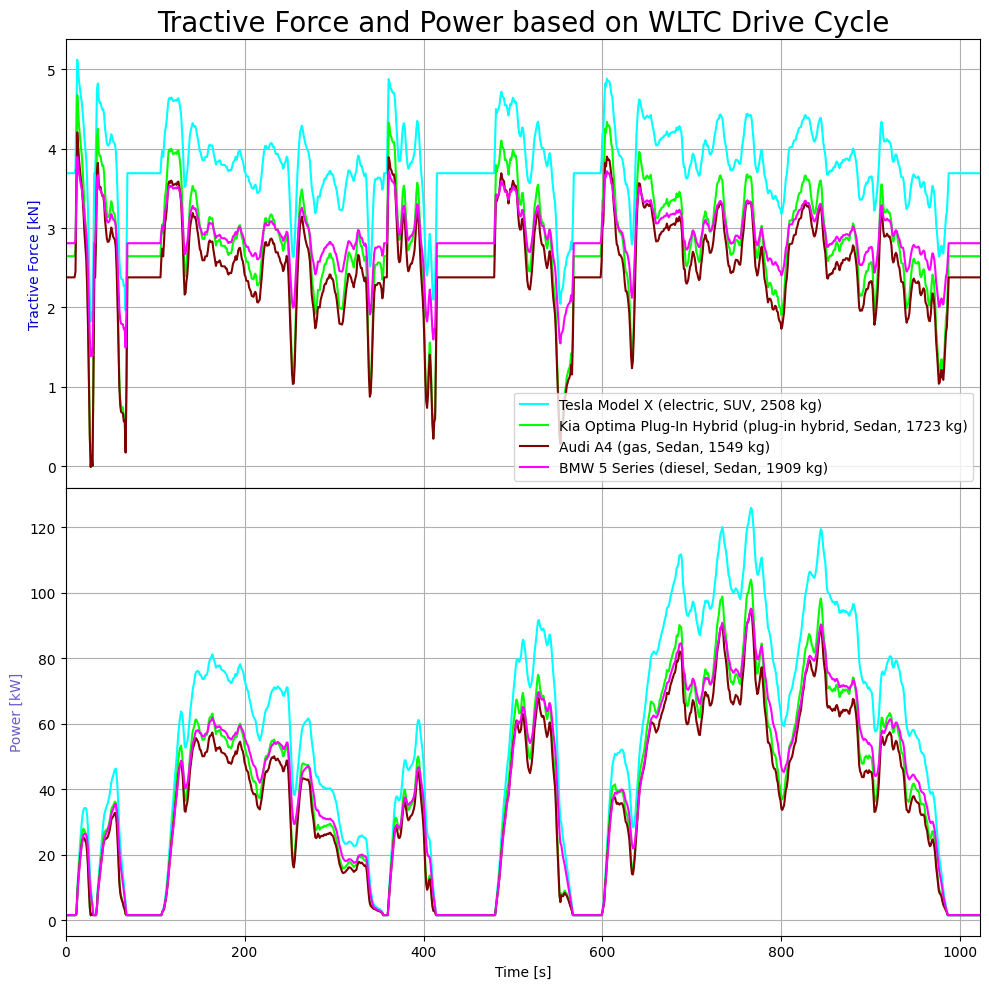

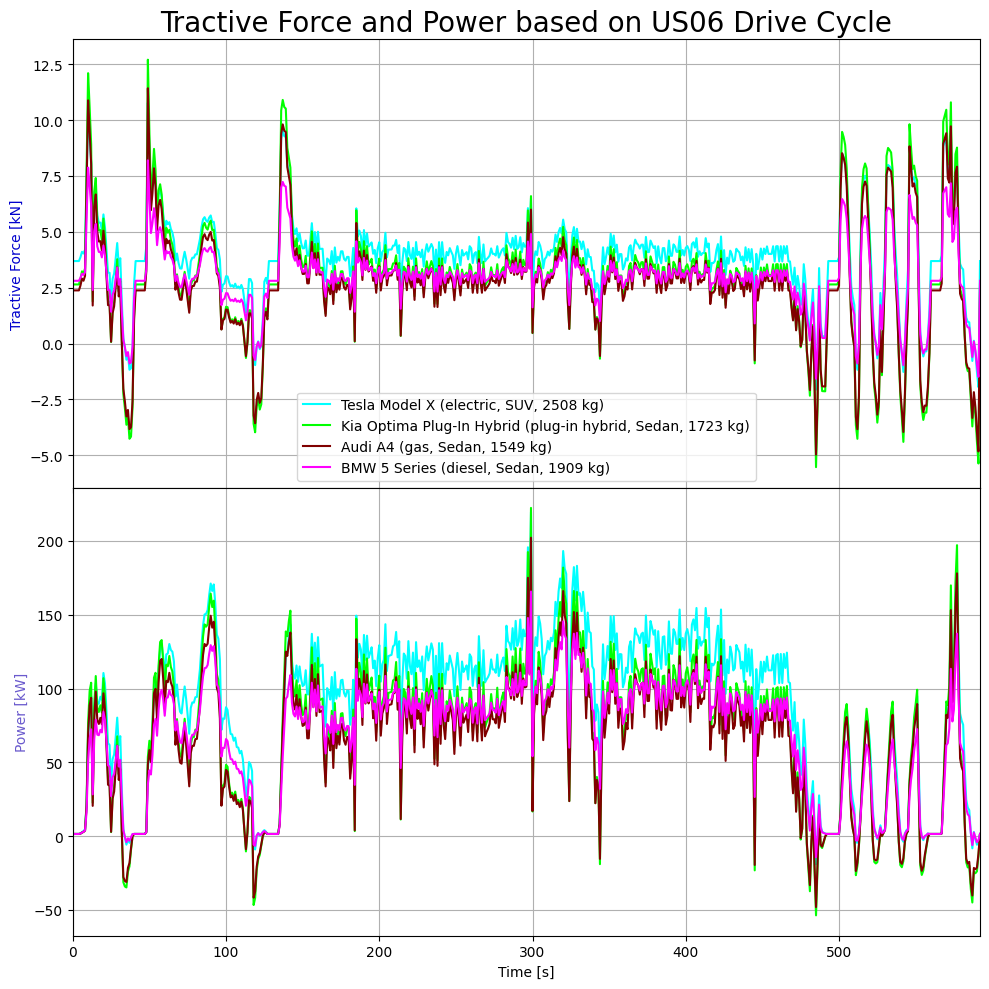

In [9]:
Tractives(wltc, 'WLTC')
Tractives(us06, 'US06')

### Efficiency & Energy

Due to friction and electrical components losses, there will always occur losses. To overcome these we introduce efficiency ratios, which compare the is-state with the ideal state. E.g. Battery charging, battery storage, inverter or grid efficiency. We distinguish the following efficiencies:

\begin{align*}
    \text{Regenerative Breaking Efficiency:} && P_{reg} & = P_{brake}\cdot\eta_{reg} \\
    \text{Power Train Efficiency:} && P_b & = \frac{P}{\eta_{pt}}
\end{align*}

The Power Train Efficiency consists of many other efficiencies of major components that transmit energy from the battery to the wheels. Typically it ranges from 80% to 90&, while the regenerative efficiency lays around 70%.

The Power $P$ can be divided into Motoring Power $P_{motor}$ and Braking Power $P_{brake}$. Braking occurs when $\dot x \cdot \ddot x < 0$, while motoring when $\dot x \cdot \ddot x \geq 0$. 

\begin{equation*}
    P(t) =  \left\{  \begin{array}{cc} 
                        P_{motor},  & \dot x \cdot \ddot x \geq 0 \\
                        P_{brake},  & \dot x \cdot \ddot x < 0  
                    \end{array}
            \right.
\end{equation*}

$P_{HVAC}$: power from heating, ventilation and air conditioning

To drive a certain amount of energy has to be inputted by the vehicle to move, this would be the motoring energy $W_{motor}$. By braking the electric and hybrid vehicles gain energy, $W_{brake}$, while the conventional cars do not gain any.

\begin{align*}
    W_b & = \int P_{b} dt = \int \frac{P}{\eta_{\text{pt}}}dt = \int P_{\text{motor}} dt = W_{\text{motor}}\\
    W_{\text{reg}} & = \int P_{\text{reg}} dt = \int \eta_{\text{reg}} P_T dt= \eta_{\text{reg}}\int P_{T} dt = \eta_{\text{reg}} W_{\text{brake}} 
\end{align*}

### Conventional Vehicles

Calculation of Fuel Energy:
\begin{equation*}
    \begin{array}{c}
        \text{Fuel} \\ 
        \text{Energy}
    \end{array}  = 
        \begin{array}{c}
            \text{Fuel Tank}\\ 
            \text{Capacity}
        \end{array} 
            \times 
        \begin{array}{c}
            \text{Energy} \\ 
            \text{Combined}
        \end{array}
\end{equation*}
The Energy Density depends on the fuel driven. Gasoline vehicles (as hybrids as well) have an Energy Density of 34.2 MJ per liter, while diesel vehicles tend to have 38.6 MJ per liter. We will call this variable as Fuel Energy and save it as 'E\_F', while symboling it as $E_F$. The new variable will have the unit kWh.

### Hybrid Vehicles

Hybrid vehicles use their electric motor primarily at low speeds (below 40 km/h), during mild acceleration ($0$ to $1.5$ m/s²), gentle deceleration, or while cruising at constant speed. When braking, the motor switches to regenerative mode to recharge the battery. The combustion engine takes over during higher speeds, stronger acceleration, or when the battery is low.

\begin{align*}
    \dot x & < 16 \text{ $\frac{\text{km}}{\text{h}}$ } \\
    \ddot x & < 2 \text{ $\frac{\text{m}}{\text{s}^2}$ }  \\
    -1.5 \text{ $\frac{\text{m}}{\text{s}^2}$ } & < \ddot
     x \\
    \ddot x \cdot \dot x & < 0
\end{align*}

In [10]:
# Algorithm 1
def cond_hyb(a, v):
    """ Returns array with conditions for 
        electric and combustione engine usage
        with 1 and -1 inputs
        1: electric engine in use
        -1: combustion engine in use
    """
    return np.where(((v*3.6) < 16) & (0 < a) & (a < 2) | 
                    (0 < a) & (a < 2) |
                    ((a == 0) & (v*3.6 <= 50)) | 
                    (((a*v)) < 0), 
                    1, -1)

def W_ice(t, v, a, P, type, eta_gas, eta_dis):
    """ Returns the Energy drawn from the combustion engine   
        (Output)
            [W_drive]: kWh
    """ 
    if type == 'gas':
        return scp.integrate.cumulative_trapezoid( np.where( a*v >= 0, P/eta_gas, 0 ), t, initial=0 ) / 3.6e6
    else:
        return scp.integrate.cumulative_trapezoid( np.where( a*v >= 0, P/eta_dis, 0 ), t, initial=0 ) / 3.6e6
    

def W_bat(t, v, a, P, eta_pt):
    """ Returns the Energy drawn from the battery 
        (Output)
            [W_bat]: kWh
    """
    return scp.integrate.cumulative_trapezoid( np.where( a*v >= 0, P/eta_pt, 0 ), t, initial=0 ) / 3.6e6

def W_reg(t, v, a, P_T, eta_reg):
    """ Returns the Energy recovered to the battery """
    return scp.integrate.cumulative_trapezoid( np.where( a*v < 0, P_T*eta_reg, 0 ), t, initial=0 ) / 3.6e6

def W_ev(t, v, a, P_T, P, eta_reg, eta_pt):
    """ Calculates the Energy drawn by the 
        battery for electric engine
        (Output)
            [W_ev]: kWh
    """
    battery = W_bat(t, v, a, P, eta_pt)
    brake = W_reg(t, v, a, P_T, eta_reg)
    return battery - brake

# Algorithm 2
def W_hyb(t, v, a, P_T, P, E_b, SoC, eta_reg, eta_pt, eta_gas):
    # Redefine all numpy arrays 
    dt = np.diff(t)
    dt = np.append(dt, dt[-1])
    v = np.array(v)
    a = np.array(a)
    P_T = np.array(P_T)
    P = np.array(P)

    # Battery value
    bat = 0 # [kWh]
    # Internal Combustion Engine Value
    ice = 0 # [kWh]

    # Energy drawn from Batter (array)
    W_bat = np.zeros(len(t))
    # Energy drawn from Combustion Engine (array)
    W_ice = np.zeros(len(t))

    # Condition array for electric engine
    cond = cond_hyb(a, v)

    for i in range(len(t)):
        # Power
        p = P[i]
        pt = P_T[i]
        if a[i]*v[i] >= 0: 
            # Motoring
            if cond[i] == 1 and bat <= (1 - SoC) * E_b:
                # Electric Motor
                bat += p / eta_pt * dt[i] / 3.6e6
            else:
                # Combustion Engine
                ice += p / eta_gas * dt[i] / 3.6e6
        else:
            # Regenerative Breaking
            bat -= pt * eta_reg * dt[i] / 3.6e6

        # Update Energy arrays
        W_bat[i] = bat
        W_ice[i] = ice
        
    # Energy needed to propel vehicle
    W = W_bat + W_ice

    # Returns: Total Energy, Combustion Engine Energy and Battery Energy
    return W, W_ice, W_bat

In [11]:
def W(dc, name, eta_reg, eta_pt, eta_gas, eta_dis):
    t = dc['Time']
    v = dc['Velocity']
    a = dc['Acceleration']
    
    # Gas Vehicle's Power
    P_g = P(gas['A'].iloc[x], gas['C'].iloc[x], gas['D'].iloc[x], v, a)

    # Diesel Vehicle's Power
    P_d = P(dis['A'].iloc[x], dis['C'].iloc[x], dis['D'].iloc[x], v, a)

    # EV's Tractive Power and Power
    P_Te = P_T(ev['A'].iloc[x], ev['C'].iloc[x], ev['D'].iloc[x], v, a)
    P_e = P(ev['A'].iloc[x], ev['C'].iloc[x], ev['D'].iloc[x], v, a)
    
    # Hybrid Vehicle's Tractive Power and Power
    P_Th = P_T(hyb['A'].iloc[x], hyb['C'].iloc[x], hyb['D'].iloc[x], v, a)
    P_h = P(hyb['A'].iloc[x], hyb['C'].iloc[x], hyb['D'].iloc[x], v, a)
    
    #Work in Gas Vehicles
    W_g = W_ice(t, v, a, P_g, 'gas', eta_gas, eta_dis)
    #Work in Diesel Vehicles
    W_d = W_ice(t, v, a, P_d, 'diesel', eta_gas, eta_dis)
    # Work in EVs
    W_e = W_ev(t, v, a, P_Te, P_e, eta_reg, eta_pt)
    # Total Work in Hybrid Vehicles
    W_h = W_hyb(t, v, a, P_Th, P_h, hyb['E_b'].iloc[x], .2, eta_reg, eta_pt, eta_gas)[0]
    # Internal Combustion Energy in Hybrid Vehicles
    W_hice = W_hyb(t, v, a, P_Th, P_h, hyb['E_b'].iloc[x], .2, eta_reg, eta_pt, eta_gas)[1]
    # Electric Energy in Hybrid Vehicles
    W_hbat = W_hyb(t, v, a, P_Th, P_h, hyb['E_b'].iloc[x], .2, eta_reg, eta_pt, eta_gas)[2]

    #SoE(t, v, a, P_T, P, E_b, eta_pt, eta_reg)
    SoEg = 1 - W_g[-1]/gas['E_f'].iloc[x]
    SoEd = 1 - W_d[-1]/dis['E_f'].iloc[x]
    SoCe = 1 - W_e[-1]/ev['E_b'].iloc[x]
    SoEh = 1 - W_hice[-1]/hyb['E_f'].iloc[x]
    SoCh = 1 - W_hbat[-1]/hyb['E_b'].iloc[x]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,9), gridspec_kw={'height_ratios': [.7],'width_ratios': [.5, .1]})

    for ax in fig.axes:
        ax.grid()

    ax1.set_xlim([dc['Time'].iloc[0], dc['Time'].iloc[-1]])
    ax1.set_xbound(lower=dc['Time'].iloc[0], upper=dc['Time'].iloc[-1])

    lbl_g = gas['Vehicle'].iloc[x] + ' (' + gas['Engine'].iloc[x] + ', ' + gas['Body'].iloc[x] + ', ' + str(int(gas['M'].iloc[x])) + ' kg): ' + str(np.around(SoEh*1e2, 2)) + "%"
    lbl_d = dis['Vehicle'].iloc[x] + ' (' + dis['Engine'].iloc[x] + ', ' + dis['Body'].iloc[x] + ', ' + str(int(dis['M'].iloc[x])) + ' kg): ' + str(np.around(SoEd*1e2, 2)) + "%"
    lbl_e = ev['Vehicle'].iloc[x] + ' (' + ev['Engine'].iloc[x] + ', ' + ev['Body'].iloc[x]+ ', ' + str(int(ev['M'].iloc[x])) + ' kg): ' + str(np.around(SoCe*1e2, 2)) + "%" 
    lbl_h = hyb['Vehicle'].iloc[x] + ' (' + hyb['Engine'].iloc[x] + ', ' + hyb['Body'].iloc[x] + ', ' + str(int(hyb['M'].iloc[x])) + ' kg)'
    lbl_hice = "Hybrid's ICE: " + str(np.around(SoEh*1e2, 2)) + "%"
    lbl_hbat = "Hybrid's Battery: " + str(np.around(SoCh*1e2, 2)) + '%'

    ax2.set_xticks([])
    ax2.set_ylim([0, 1])

    ax1.plot(t, W_g, label=lbl_g, c='maroon')
    ax1.plot(t, W_d, label=lbl_d, c='magenta')
    ax1.plot(t, W_e, label=lbl_e, c='cyan')
    ax1.plot(t, W_h, label=lbl_h, c='lime')
    ax1.plot(t, W_hice, label=lbl_hice, c='hotpink', alpha=.6)
    ax1.plot(t, W_hbat, label=lbl_hbat, c='cadetblue', alpha=.6)

    # Bar Plot
    container = list(range(5))
    h = 1*len(container)
    colors = ['maroon', 'magenta', 'cyan', 'hotpink', 'cadetblue']
    SoE_list = [SoEg, SoEd, SoCe, SoEh, SoCh]

    ax2.bar(container, h, color=colors, alpha=.3)
    ax2.bar(container, SoE_list, color=colors)
    ax2.yaxis.tick_right()

    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

    plt.subplots_adjust(wspace=0)

    ax1.legend()
    ax2.margins(x=0)

    ax1.set_title(f'Energy Consumption for {name} Drive Cicle', loc='center', size=20)
    ax2.set_title('Source State')
    fig.set_tight_layout(True)
    plt.savefig('paper/images/W_'+name, dpi=100)

    plt.show()

/var/folders/9n/q_3nsbg13pb4xyqk11p6058h0000gn/T/ipykernel_3707/3302207405.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


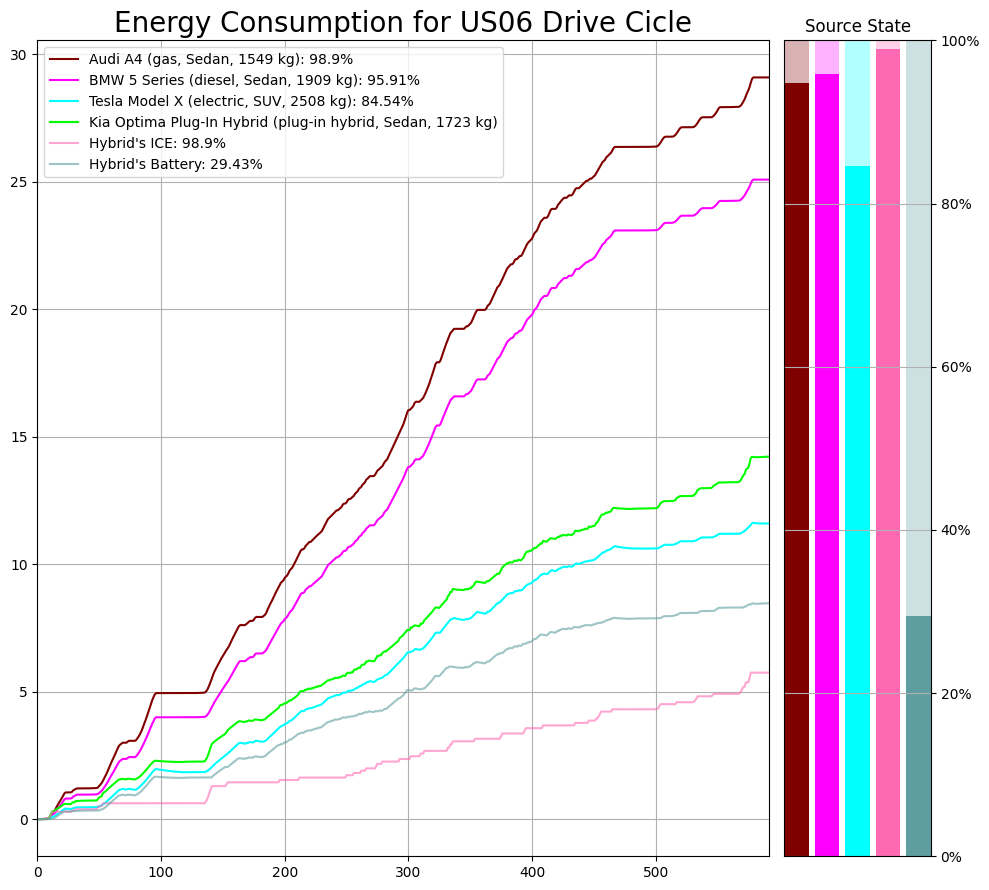

/var/folders/9n/q_3nsbg13pb4xyqk11p6058h0000gn/T/ipykernel_3707/3302207405.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


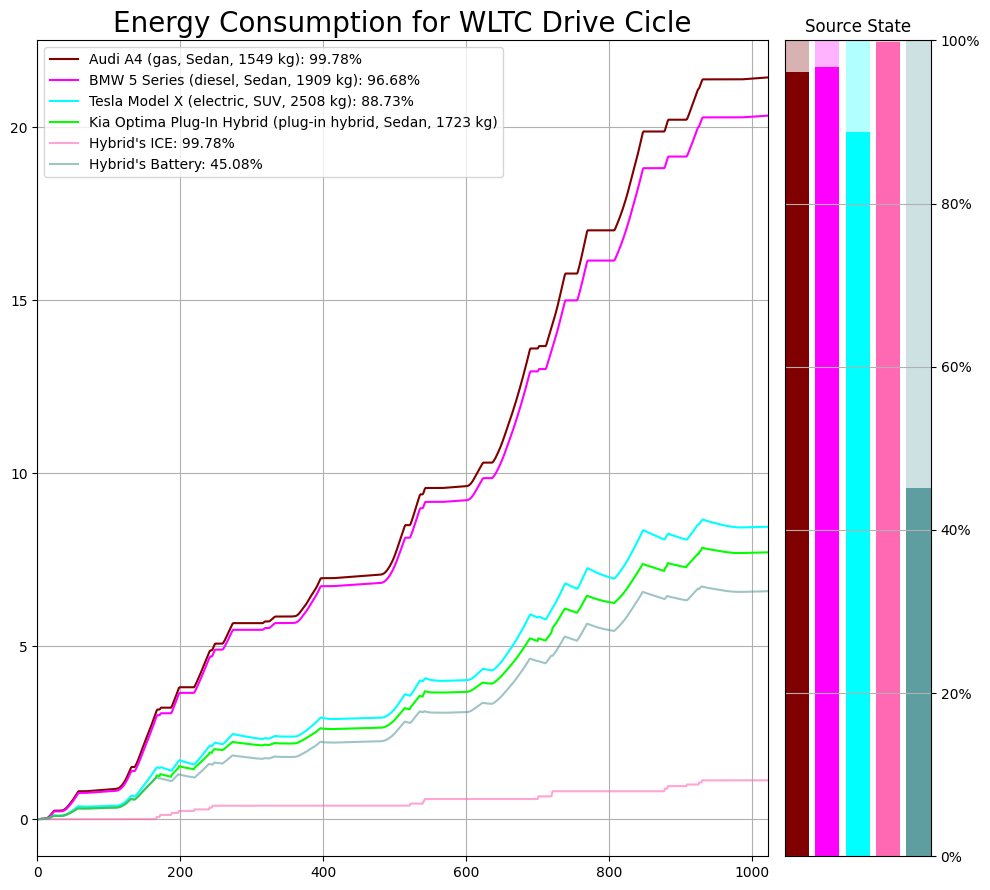

In [12]:
W(us06, 'US06', eta_reg=.35, eta_pt=.75, eta_gas=.27, eta_dis=.3)
W(wltc, 'WLTC', .35, .75, .27, .3)

### Fuel Consumption $\left(FC\right)$

\begin{equation*}
    FC = \frac{W_{drive}}{S}
\end{equation*}

In [13]:
def FC(t, s, v, a, P_T, P, type, eta_reg, eta_pt, eta_gas, eta_dis, SoC=.2, E_b=0):
    """ Calculates the Fuel Consumption
        (Input)
            S: Distance, [m]
            W_drive: Energy, [kWh]
        (Output) 
            FC: Fuel Consumption [kWh/km] """
    S = s.iloc[-1]*1e-3
    if type == 'gas':
        return W_ice(t, v, a, P, type, eta_gas, eta_dis)[-1]/S
    elif type == 'diesel':
        return W_ice(t, v, a, P, type, eta_gas, eta_dis)[-1]/S
    elif type == 'electric':
        return W_ev(t, v, a, P_T, P, eta_reg, eta_pt)[-1]/S
    else:
        return (W_hyb(t, v, a, P_T, P, E_b, SoC, eta_reg, eta_pt, eta_gas)[0]/S)[-1]

In [14]:
def ITER(dc_name, A, C, D, engine, eta_reg, eta_pt, eta_gas, eta_dis, SoC=.2, E_b=0):
    """ Goes through all the processes above
        to calculate the FC
        (Input)
            DC: Drive Cycle
            A: Coefficient A
            C: Coefficient C
            D: Coefficient D
    """
    # Read Drive Cycle
    DC = pd.read_csv(dc_name)

    # Drive Cycle Variables
    t = DC['Time']
    s = DC['Distance']
    v = DC['Velocity']
    a = DC['Acceleration']

    p_t = P_T(A, C, D, v, a)
    p = P(A, C, D, v, a)
    return FC(t, s, v, a, p_t, p, engine, eta_reg, eta_pt, eta_gas, eta_dis, SoC, E_b)

In [15]:
for conv in [gas, dis]:
    conv['FC US06'] = np.vectorize(ITER)('Data/us06.csv', conv['A'], conv['C'], conv['D'], conv['Engine'], .35, .75, .27, .3)
    conv['FC WLTC'] = np.vectorize(ITER)('Data/wltc.csv', conv['A'], conv['C'], conv['D'], conv['Engine'], .45, .75, .27, .3)

for elec in [ev, hyb]:
    elec['FC US06'] = np.vectorize(ITER)('Data/us06.csv', elec['A'], elec['C'], elec['D'], elec['Engine'], .35, .75, .27, .3, 0.2, elec['E_b'])
    elec['FC WLTC'] = np.vectorize(ITER)('Data/wltc.csv', elec['A'], elec['C'], elec['D'], elec['Engine'], .45, .75, .27, .3, 0.2, elec['E_b'])

Create Vehicles Data Frame

In [16]:
vehicles = pd.concat([ev, hyb, gas, dis]).fillna(0)
group_body = vehicles[['Body', 'Engine', 'FC US06', 'FC WLTC']].groupby(['Body', 'Engine'])
vehicles.to_csv('Data/vehicles.csv', index=False)
dfi.export(group_body.mean(numeric_only=True).transpose(), 'paper/images/FC.png', table_conversion='matplotlib')

We exclude the Convertibles and Trucks, as their representants do not contain any electric motors!

In [17]:
grouped1 = vehicles[vehicles['Body'].str.contains('Sedan|Hatchback')]
grouped2 = vehicles[~vehicles['Body'].str.contains('SUV|Sedan|Hatchback|Convertible|Truck')]
grouped3 = vehicles[vehicles['Body'].str.contains('SUV')]
group_body1 = grouped1[['Body', 'Engine', 'FC US06', 'FC WLTC']].groupby(['Body', 'Engine']).mean(numeric_only =True)
group_body2 = grouped2[['Body', 'Engine', 'FC US06', 'FC WLTC']].groupby(['Body', 'Engine']).mean(numeric_only =True)
group_body3 = grouped3[['Body', 'Engine', 'FC US06', 'FC WLTC']].groupby(['Body', 'Engine']).mean(numeric_only =True)
dfi.export(group_body1.transpose(), 'paper/images/FC1.png', table_conversion='matplotlib') 
dfi.export(group_body2.transpose(), 'paper/images/FC2.png', table_conversion='matplotlib')
dfi.export(group_body3.transpose(), 'paper/images/FC3.png', table_conversion='matplotlib')

In [18]:
group_body1.transpose()

Body    Hatchback                                        Sedan            \
Engine     diesel  electric       gas plug-in hybrid    diesel  electric   
FC US06  1.917004  0.688301  1.964537       1.003624  2.005238  0.802561   
FC WLTC  1.392743  0.426079  1.442597       0.507682  1.528688  0.518212   

Body                              
Engine        gas plug-in hybrid  
FC US06  2.228575       1.131156  
FC WLTC  1.673927       0.586951

In [19]:
group_body2.transpose()

Body        Coupe                    Wagon                                   
Engine        gas plug-in hybrid    diesel  electric       gas plug-in hybrid
FC US06  2.108834       0.976307  1.965671  0.728156  2.208677       0.874123
FC WLTC  1.578243       0.530098  1.428193  0.447484  1.679698       0.489600

In [20]:
group_body3.transpose()

Body          SUV                                   
Engine     diesel  electric       gas plug-in hybrid
FC US06  2.150523  0.889010  2.442687       1.103319
FC WLTC  1.704287  0.566658  1.861112       0.607724

In [21]:
con = vehicles[vehicles['Body'] == 'Convertible']
suv = vehicles[vehicles['Body'] == 'SUV']
hbk = vehicles[vehicles['Body'] == 'Hatchback']
cpe = vehicles[vehicles['Body'] == 'Coupe']
wag = vehicles[vehicles['Body'] == 'Wagon']
sed = vehicles[vehicles['Body'] == 'Sedan']
trk = vehicles[vehicles['Body'].str.contains('Truck')]

In [22]:
def clr(engine):
    clr_map = {'gas': 'mediumvioletred',
               'diesel': 'mediumseagreen',
               'electric': 'dodgerblue',
               'hybrid': 'mediumpurple',
               'plug-in hybrid': 'mediumpurple'
            }
    try:
        return clr_map[engine]
    except KeyError:
        return 0
    
vehicles['Color'] = np.vectorize(clr)(vehicles['Engine'])

In [23]:
vehicles['Body'].unique()

suv = vehicles[vehicles['Body'] == 'SUV']
hbk = vehicles[vehicles['Body'] == 'Hatchback']
cpe = vehicles[vehicles['Body'] == 'Coupe']
wag = vehicles[vehicles['Body'] == 'Wagon']
sed = vehicles[vehicles['Body'] == 'Sedan']

In [24]:
final = vehicles[~vehicles['Body'].str.contains('Convertible|Truck')]

In [25]:
suv['Drive'].unique()

array(['all wheel drive', 'front wheel drive', 'four wheel drive',
       'rear wheel drive'], dtype=object)

/var/folders/9n/q_3nsbg13pb4xyqk11p6058h0000gn/T/ipykernel_3707/2393855645.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[-1, 0].set_xticklabels([i/2 for i in range(7)])
/var/folders/9n/q_3nsbg13pb4xyqk11p6058h0000gn/T/ipykernel_3707/2393855645.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[-1, 1].set_xticklabels([i/2 for i in range(7)])


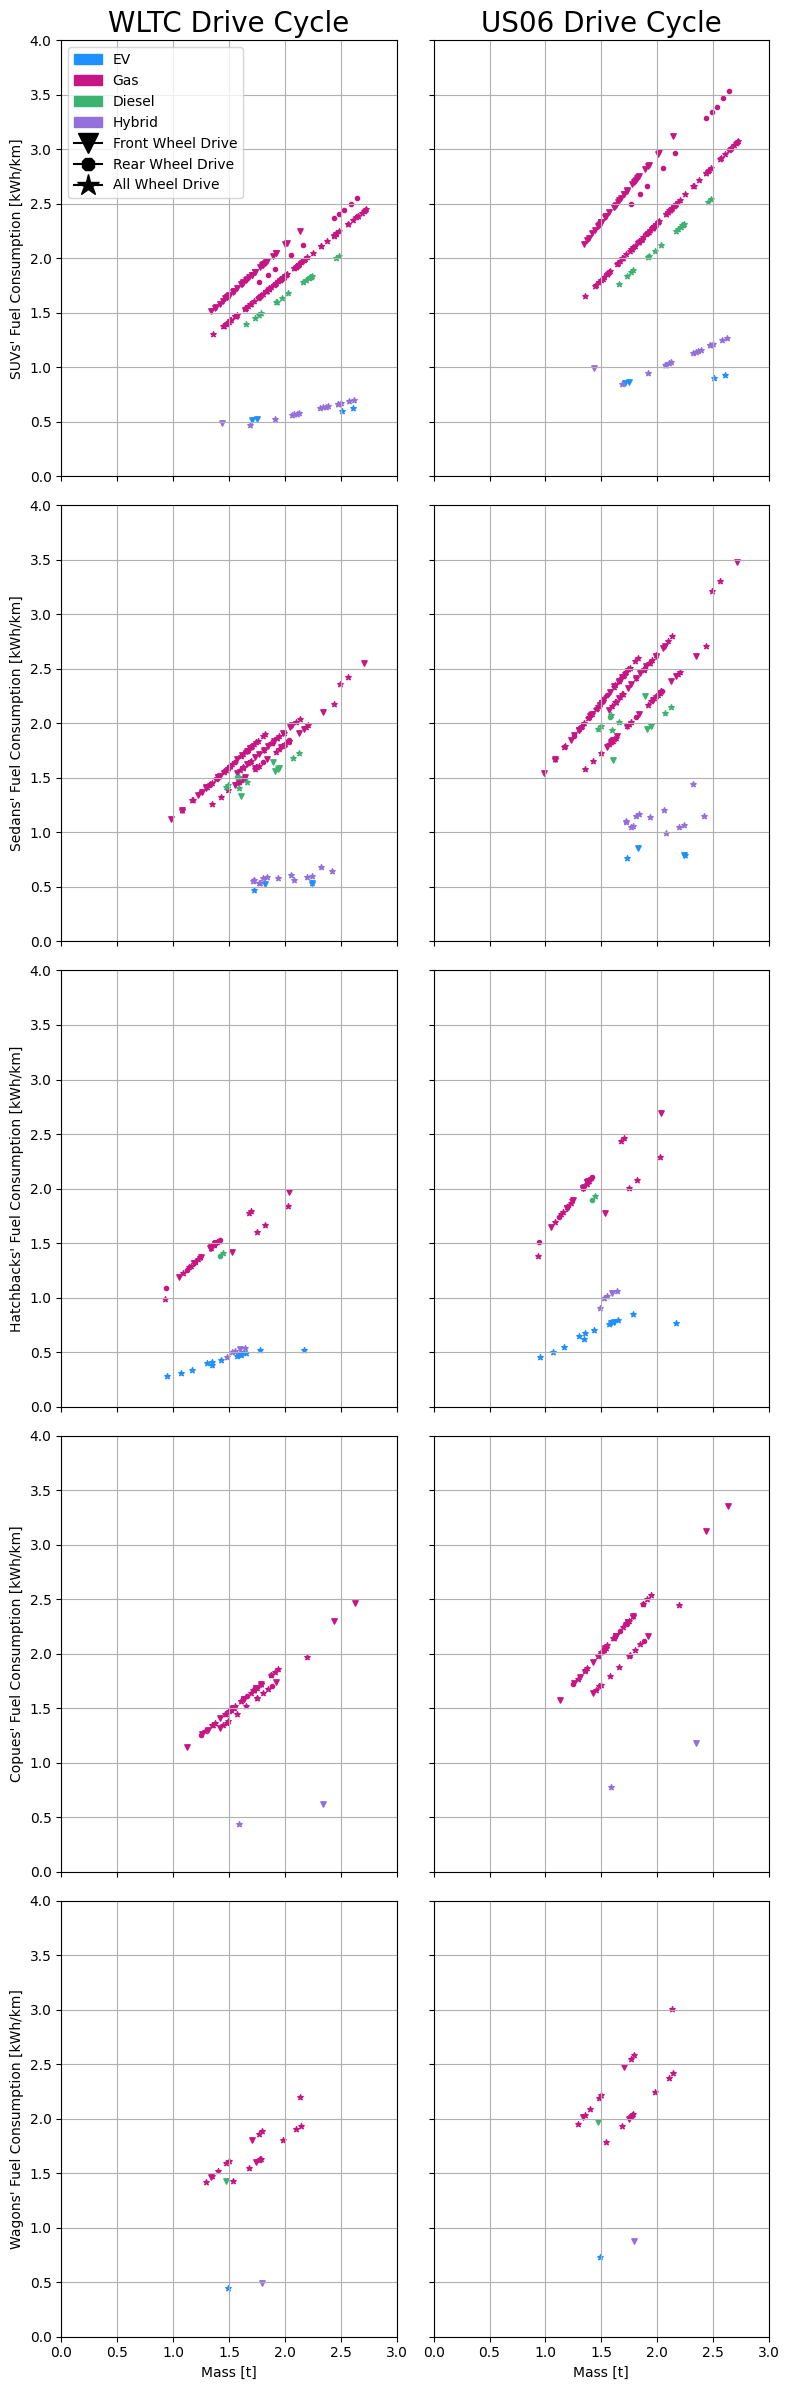

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(8, 24))
# Marker does not allow arrays -> iteration (slowest possible solution)

marker = ['.', '8', 's', '*', '+']
type = [suv, sed, hbk, cpe, wag]
fig.set_tight_layout(True)

for i in range(5):
    for k in range(len(type[i])):
        if suv['Drive'].iloc[k] == 'front wheel drive':
            ax[i,0].scatter(type[i]['M'].iloc[k], type[i]['FC WLTC'].iloc[k], color=type[i]['Color'].iloc[k], s=15, marker='v')
            ax[i,1].scatter(type[i]['M'].iloc[k], type[i]['FC US06'].iloc[k], color=type[i]['Color'].iloc[k], s=15, marker='v')
        elif suv['Drive'].iloc[k] == 'rear wheel drive':
            ax[i,0].scatter(type[i]['M'].iloc[k], type[i]['FC WLTC'].iloc[k], color=type[i]['Color'].iloc[k], s=10,marker='8')
            ax[i,1].scatter(type[i]['M'].iloc[k], type[i]['FC US06'].iloc[k], color=type[i]['Color'].iloc[k], s=10,marker='8')
        else:
            ax[i,0].scatter(type[i]['M'].iloc[k], type[i]['FC WLTC'].iloc[k], color=type[i]['Color'].iloc[k], s=16,marker='*')
            ax[i,1].scatter(type[i]['M'].iloc[k], type[i]['FC US06'].iloc[k], color=type[i]['Color'].iloc[k], s=16,marker='*')
    ax[i, 1].set_yticklabels([])

for i in range(4):
    ax[i, 0].set_xticklabels([])
    ax[i, 1].set_xticklabels([])

# X-Labels and -Ticks
ax[0,0].set_title('WLTC Drive Cycle', size=20)
ax[0,1].set_title('US06 Drive Cycle', size=20)
ax[-1, 0].set_xticklabels([i/2 for i in range(7)])
ax[-1, 1].set_xticklabels([i/2 for i in range(7)])
ax[-1, 0].set_xlabel('Mass [t]')
ax[-1, 1].set_xlabel('Mass [t]')

ax[0, 0].set_ylabel("SUVs' Fuel Consumption [kWh/km]")
ax[1, 0].set_ylabel("Sedans' Fuel Consumption [kWh/km]")
ax[2, 0].set_ylabel("Hatchbacks' Fuel Consumption [kWh/km]")
ax[3, 0].set_ylabel("Copues' Fuel Consumption [kWh/km]")
ax[4, 0].set_ylabel("Wagons' Fuel Consumption [kWh/km]")

# Y-Labels
ev_patch = mpatches.Patch(color='dodgerblue', label='EV')
gas_patch = mpatches.Patch(color='mediumvioletred', label='Gas')
dis_patch = mpatches.Patch(color='mediumseagreen', label='Diesel')
hyb_patch = mpatches.Patch(color='mediumpurple', label='Hybrid')
fwd_line = mlines.Line2D([], [], color='black', marker='v', markersize=15, label='Front Wheel Drive')
rwd_line = mlines.Line2D([], [], color='black', marker='8', markersize=10, label='Rear Wheel Drive')
awd_line = mlines.Line2D([], [], color='black', marker='*', markersize=16, label='All Wheel Drive')
ax[0,0].legend(handles=[ev_patch, gas_patch, dis_patch, hyb_patch, fwd_line, rwd_line, awd_line])

for ax in fig.axes:
    ax.grid()
    ax.set_ylim([ int(min(final[['FC US06', 'FC WLTC']].min())), np.ceil(max(final[['FC US06', 'FC WLTC']].max())) ])
    ax.set_xlim([ 0, np.ceil((final['M'].max())/1000)*1000])

plt.savefig('Paper/images/Final', dpi=100)

In [27]:
grouped = vehicles[~vehicles['Body'].str.contains('Convertible|Truck|Coupe')]
mn = grouped[['Body', 'Engine', 'FC US06', 'FC WLTC']].groupby(['Body', 'Engine']).min(numeric_only=True)
mx = grouped[['Body', 'Engine', 'FC US06', 'FC WLTC']].groupby(['Body', 'Engine']).max(numeric_only=True)

In [28]:
dfi.export(mx, 'paper/images/FCmax.png', table_conversion='matplotlib')
dfi.export(mn, 'paper/images/FCmin.png', table_conversion='matplotlib')

In [29]:
def percentage_gain(df):
    # Reset Index
    grouped_reset = df.reset_index()
    results = []

    for body in grouped_reset['Body'].unique():
        body_group = grouped_reset[grouped_reset['Body'] == body]

        # Fuel Consumption
        electric_row = body_group[body_group['Engine'] == 'electric']
        if electric_row.empty:
            # Skip electric
            continue

        fc_us06_e = electric_row['FC US06'].values[0]
        fc_wltc_e = electric_row['FC WLTC'].values[0]

        for _, row in body_group.iterrows():
            if row['Engine'] == 'electric':
                # Skip electric
                continue

            gain_us06 = ((row['FC US06'] - fc_us06_e) / row['FC US06']) * 100
            gain_wltc = ((row['FC WLTC'] - fc_wltc_e) / row['FC WLTC']) * 100

            results.append({'Body': body,
                            'Engine': row['Engine'],
                            'WLTC %': round(gain_wltc, 2),
                            'US06 %': round(gain_us06, 2)
            })

    # Result
    efficiency_comparison_df = pd.DataFrame(results)
    return efficiency_comparison_df

In [30]:
dfi.export(percentage_gain(mn), 'paper/images/FCminpercent.png', table_conversion='matplotlib')
dfi.export(percentage_gain(mx), 'paper/images/FCmaxpercent.png', table_conversion='matplotlib')

In [31]:
percentage_gain(mn).groupby(['Engine']).min()

,Body,WLTC %,US06 %
Engine,,,
diesel,Hatchback,63.05,51.73
gas,Hatchback,57.99,48.41
plug-in hybrid,Hatchback,-9.65,-0.43


In [32]:
percentage_gain(mn).groupby(['Engine']).max()

,Body,WLTC %,US06 %
Engine,,,
diesel,Wagon,79.72,75.87
gas,Wagon,71.57,66.71
plug-in hybrid,Wagon,38.86,49.45


In [33]:
percentage_gain(mx).groupby('Engine').max()

,Body,WLTC %,US06 %
Engine,,,
diesel,Wagon,69.14,63.31
gas,Wagon,79.66,75.79
plug-in hybrid,Wagon,21.46,40.41


In [34]:
percentage_gain(mx).groupby('Engine').min()

,Body,WLTC %,US06 %
Engine,,,
diesel,Hatchback,62.91,56.22
gas,Hatchback,73.47,68.59
plug-in hybrid,Hatchback,3.19,16.70
